In [1]:
# Type annotations :
from typing import Tuple, List, Optional, NoReturn, Callable, Any, Dict

# Standard and OS :
import copy
import json
import glob
import os
import importlib # Required to reload a module
                 # because the Jupyter Kernel
                 # won't  really reimport by itself.
import multiprocessing as mp

# Image processing :
import cv2 as cv
import skimage
from skimage.feature import canny, peak_local_max
from skimage.util.dtype import dtype_range
from skimage.util import img_as_ubyte, img_as_float
from skimage import exposure
import skimage.morphology as morphology
from skimage.morphology import disk, skeletonize, thin, medial_axis, watershed, max_tree, convex_hull_image, closing
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
import skimage.measure as measure
import skimage.draw as draw
from skimage.color import label2rgb
#from skimage.morphology import black_tophat, skeletonize, convex_hull_image
#from skimage.morphology import disk

from skimage.filters import rank
from skimage.measure import label, regionprops

# Numeric :
import numpy as np
import pandas as pd
from scipy import ndimage as ndi

# Visualisation :
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Machine-Learning :
from sklearn.cluster import KMeans

# Functional programing tools : 
from functools import partial, reduce
from itertools import islice, chain, repeat
from operator import itemgetter


In [2]:
# Modules defined within this repo :
import mfilt_funcs as mfs
importlib.reload(mfs)
import mfilt_funcs as mfs

import utils
importlib.reload(utils)
import utils

import forutils
importlib.reload(forutils)
from forutils import find_branch_points

In [3]:
lmap = lambda x, y: list(map(x, y))
lfilter = lambda x, y: list(filter(x, y))
imread = lambda x: cv.imread(x, 0)
pad_obj = lambda x: cv.copyMakeBorder(np.float64(x.image), 10, 10, 10, 10, cv.BORDER_CONSTANT)
pad  = lambda x: cv.copyMakeBorder(np.float64(x), 10, 10, 10, 10, cv.BORDER_CONSTANT)
pad1 = lambda x: cv.copyMakeBorder(np.float64(x), 1, 1, 1, 1, cv.BORDER_CONSTANT)

In [4]:
plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (12, 8)

In [49]:

#################################### Tested and functional : #######################################

def chunk_pad(it, size, padval=None):
    """
        Splits a list into evenly sized chunks.
        Taken from : https://stackoverflow.com/questions/312443/how-do-you-split-a-list-into-evenly-sized-chunks
    """
    it = chain(iter(it), repeat(padval))
    return iter(lambda: tuple(islice(it, size)), (padval,) * size)
##

def segplot(
    img: np.ndarray, 
    group: skimage.measure._regionprops.RegionProperties, 
    color: Optional[str] = None,
    title: Optional[str] = None
) -> NoReturn:
    """
    """
    if not color:
        color = 'red'
        
    fig, ax = plt.subplots(figsize=(9, 9))
    ax.imshow(img, cmap='gray')

    try:
        iter(group)
        for region in group:
            minr, minc, maxr, maxc = region.bbox
            rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                      fill=False, edgecolor=color, linewidth=2)
            ax.add_patch(rect)
    except:
        minr, minc, maxr, maxc = group.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                                 fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(rect)
        
    
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()
##

def watershed_viz(image, distance, labels):
    """
        Constructed from the example found in :
        https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html
    """
    fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
    ax = axes.ravel()

    ax[0].imshow(image, cmap=plt.cm.gray)
    ax[0].set_title('Overlapping objects')
    ax[1].imshow(-distance, cmap=plt.cm.gray)
    ax[1].set_title('Distances')
    ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
    ax[2].set_title('Separated objects')

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()
    plt.show()
##

def ez_watershed(
    image: np.ndarray, 
    markers: Optional[int] = None, 
    footprint: Optional[np.array] = None, 
    **kw
) -> Tuple[int, int, int]:
    """
    """
    distance = ndi.distance_transform_edt(image)
    if footprint is not None:
        fp = footprint
    else:
        fp = np.ones((10, 10))
    
    if markers is None:
        local_maxi = peak_local_max(
            distance, 
            indices=False, 
            footprint=np.ones((10, 10)),
            labels=image,
            **kw
        )
        markers = ndi.label(local_maxi)[0]

    labels  = watershed(-distance, markers, mask=image)
    
    return markers, distance, labels
##

def auto_segment(
    img: np.ndarray, 
    groups: int = 2,
    skew: Optional[float] = None,
    nonzero: bool = False,
    verbose: bool = False, 
    save_file: Optional[str] = None,
    figsize: Optional[Tuple[int]] = (12, 8)
) -> np.ndarray:
    """
        Segment (by thresholding)
    """
    
    assert type(groups) is int, f"type(groups) == '{type(groups)}', should be int."
    
    #Create the destination image from the image passed to the function, casting it when needed.
    _floats = [np.float, np.float16, np.float32, np.float64, np.float128]
    if img.dtype in _floats:
        dst: np.ndarray = copy.deepcopy(img)
    else:
        dst: np.ndarray = copy.deepcopy(np.float64(img) / 255)
    
    # We perform K-Means clustering analysis :
    _intensities = img.flatten()
    _show_intensities = _intensities.copy()
    if nonzero:
        _intensities = _intensities[_intensities.nonzero()]
    _kmeans = KMeans(n_clusters=groups, random_state=0, verbose=verbose).fit(_intensities.reshape(-1, 1))
    _centers = pd.core.frame.DataFrame({
        "means": chain.from_iterable(_kmeans.cluster_centers_)
    })
    _centers = _centers.sort_values(by=['means'])
    
    # We obtain our threshold values as pairwise means between cluster centers.
    _centers['k'] = _centers.rolling(2).mean()
    
    # If we desire to skew the thresholding process, we modify the K series :
    if skew is not None:
        _centers['k'] = _centers['k'].apply(lambda x: x + skew)
    
    # Create the values that will fill the image, according to the thresholds.
    _fill_vals = np.linspace(0, 1, groups, dtype=np.float64)
    
    # Fill the image with trheshold values.
    ks = [0] + _centers['k'].dropna().tolist()
    for j in range(len(ks) - 1):
        _mask = np.nonzero( (img > ks[j]) & (img < ks[j+1]) )
        dst[ _mask ] = _fill_vals[j]
    _mask = np.nonzero( img > ks[-1] )
    dst[ _mask ] = _fill_vals[-1]
    
    if verbose:
        fig = plt.figure(figsize = figsize)
        if skew is not None:
            print(f"\n\n Each one of the K's was skewed by a value of {skew}\n\n")
        lmap(lambda x: plt.axvline(x, color='r'), _centers.k.dropna())
        lmap(lambda x: plt.axvline(x, color='g'), _centers.means)
        _ = sns.distplot(_show_intensities, kde=False)
        fig2 = plt.figure(figsize = figsize)
        fig2.add_subplot(1, 2, 1)
        plt.imshow(img, cmap = 'gray')
        plt.title('Original')
        fig2.add_subplot(1, 2, 2)
        plt.imshow(dst, cmap = 'gray')
        plt.title(f"Threshold ({groups} groups)")
        
    return dst
##

def ref_region(
    img: np.ndarray,
    selem: Any = disk(5),
    sigma: int = 3,
    opening_se: np.ndarray = np.ones((10, 10)),
    closing_se: np.ndarray = np.ones((5, 5)),
    verbose: bool = False
):
    """
    """
    
    # Perform histogram equalisation :
    _img_eq = rank.equalize(img, selem=selem)
    
    # Perform edge detection :
    _edges = canny(_img_eq, sigma=3)
    _filled = ndi.binary_fill_holes(_edges)
    
    # Morphological processing :
    _eroded = utils.closing(
        utils.opening(np.float64(_filled), opening_se), closing_se
    )
    
    if verbose:
        utils.side_by_side(img, _img_eq, title1="Original", title2="Histogram Equalised")
        #plt.title('Lol')
        utils.side_by_side(_img_eq, _filled, title1="Histogram Equalised", title2="Canny Edge Detection + Filled image")
        #plt.title('Lal')
        utils.side_by_side(_filled, _eroded, title1="Canny Edge Detection + Filled image", title2="Opening, closing")
        #plt.title('Lel')
        
    return _eroded
##

def subdivide_hose(
    img: np.ndarray, 
    n: int = 2, 
    contiguous: bool = False,
    disksize: Optional[float] = None
) -> List[np.ndarray]:
    """
        Subdivide a hose into n chunks, automatically.
    """
    
    _edges = canny(img)
    _label_image = label(_edges, return_num=False)
    _objs = regionprops(_label_image)
    
    _smallest = reduce(lambda x, y: x if x.area < y.area else y, _objs)
    _largest  = reduce(lambda x, y: x if x.area > y.area else y, _objs)
    
    if contiguous:
        # Sort according to columns. 
        _short = np.array(sorted(_smallest.coords, key=itemgetter(1)))
        _long  = np.array(sorted(_largest.coords,  key=itemgetter(1)))
    else:
        _short = _smallest.coords
        _long  = _largest.coords
    
    _small_chunks = np.array_split(_short, n)
    _large_chunks = np.array_split(_long, n)
    
    # Create n subdivision masks : 
    _masked = [np.zeros_like(img, dtype=img.dtype) for i in range(n)]
    
    for i in range(len(_masked)):
        for _coord in _small_chunks[i]:
            _masked[i][tuple(_coord)] = 1
        for _coord in _large_chunks[i]:
            _masked[i][tuple(_coord)] = 1
    
    disksize = disksize if disksize is not None else 13
    
    return [ cv.bitwise_and(np.uint8(img), np.uint8(morphology.dilation(_mask, disk(disksize)))) for _mask in _masked ]
##


def plot_label_image_regions(img: np.ndarray) -> NoReturn:
    """
    """
    # label image regions
    label_image = label(img)
    image_label_overlay = label2rgb(label_image, image=img)
    font = cv.FONT_HERSHEY_SIMPLEX 
    color = (255, 0, 0)
    letrero = 1
    thickness = 1

    fig, ax = plt.subplots(figsize=(10, 6))
    #ax.imshow(image_label_overlay)

    for region in regionprops(label_image):
        # draw rectangle around segmented labels
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle((minc, minr), maxc - minc, maxr - minr,
                            fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)
        y0, x0 = region.centroid
        y0 = int(y0)
        x0 = int(x0)
        org = (x0, y0)
        image_label_overlay = cv.putText(image_label_overlay, str(letrero), org, font, 1, color, thickness, cv.LINE_AA)
        letrero += 1
    
    ax.imshow(image_label_overlay)
    ax.set_axis_off()
    plt.tight_layout()
    plt.show()
    plt.close()
##

#################################### Experimental : #######################################

def my_thinning(img: np.ndarray, se: np.ndarray) -> np.ndarray:
    """
    """
    
    return  np.bitwise_xor(img, ndi.binary_hit_or_miss(img, se))


def prune(img: np.ndarray, n: int = 1):
    """
        This function DOES NOT WORK !
        HOW IS A DON'T CARE ELEMENT IMPLEMENTED IN PYTHON ?
        :(
    """
     # Construct all of the structuring elements needed from clockwise rotations.
    clockwise_rotations = lambda y: [y] + list(map(lambda x: np.rot90(y, x), reversed(range(1, 3+1))))
    _b1 = np.array([[1, 0, 0],[1, 1, 0],[1, 0, 0]], dtype=img.dtype)
    _b2 = np.array([[1, 0, 0],[0, 1, 0],[0, 0, 0]], dtype=img.dtype)
    B = reduce(
        lambda x, y: x + y, 
        lmap(clockwise_rotations, [_b1, _b2])
    )
    H = np.ones((3, 3))
    
    # Thinning, by all of the structuring elements :
    
    X1 = reduce(thinning, B, img)
    while n > 1:
        X1 = reduce(thinning, B, X1)
        n -= 1
    
    return X1
    
    # Hit or miss stage :
    #X2 = reduce(ndi.binary_hit_or_miss, B, X1)

    #return X2
    
    # Dilation stage : 
    #X3 = cv.dilate(X2, H)
    # Hit-or-miss
    #ndi.binary_hit_or_miss  
##

In [6]:
ls images/

Triangulos.PNG   altoflujo.png    bajo2flujo.png   triangulos2.jpg
alto2flujo.png   bajo1flujo.png   bajo3flujo.png


In [7]:
cwd  = os.path.abspath('.')
path = os.path.join(cwd, 'images')
pattern = os.path.join(path, '*flujo.png')
files = glob.glob(pattern)
files

['/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/altoflujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/bajo1flujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/bajo2flujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/bajo3flujo.png',
 '/Users/gml/Documents/IX/imagenes/ProyectoAsignadoImagenes/images/alto2flujo.png']

Todas nuestras imágenes de interés contienen la cadena de caracteres 'flujo.png'.

In [8]:
llaves = lmap(lambda x: os.path.split(x)[-1], files)

In [9]:
mangueras = {
    f"{nombre}": imread(file) for file, nombre in zip(files, llaves) 
}

In [10]:
intensities = pd.core.frame.DataFrame({
    key: mangueras[key].flatten() for key in mangueras.keys()
})

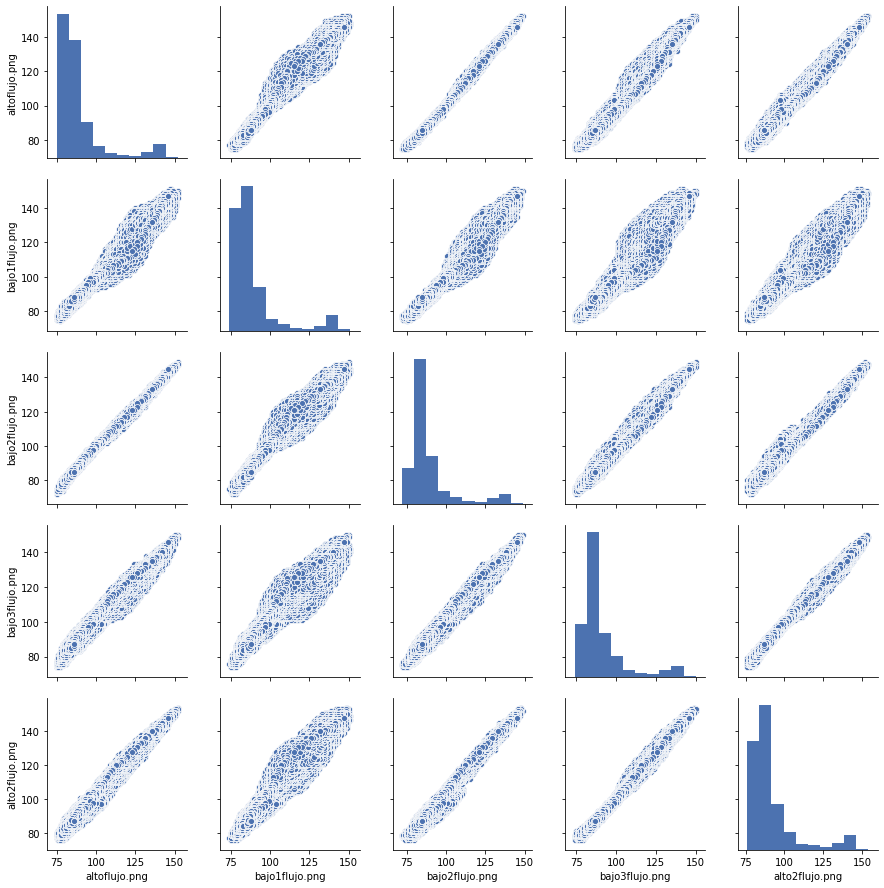

In [9]:
# SUPER SLOW ! 
# Do not run !
sns.pairplot(intensities)

Podemos observar una gran correlación entre las intensidades de todas las imágenes.

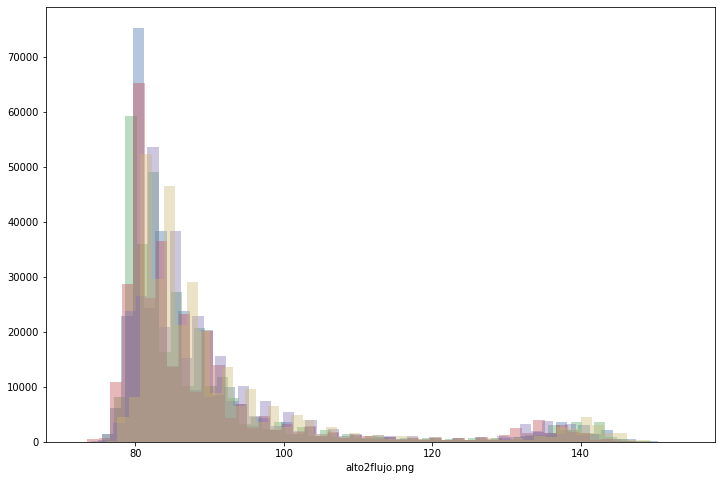

In [11]:
for i in intensities:
    sns.distplot(intensities[i],  kde=False)

Nótese lo similares que son las distribuciones de las intensidades, independientemente de la intensidad del flujo.

In [12]:
mangueras_segmentadas = {
    key: auto_segment(mangueras[key], verbose=False, groups=2, skew=None) for key in mangueras.keys()
}

Aquí segmentamos automáticamente la región de la manguera, gracias al gran contraste que existe entre éste nuestro ente de interés y el fondo (muy claro el primero, oscuro el segundo).

Usamos la función que diseñamos : ```auto_segment()```

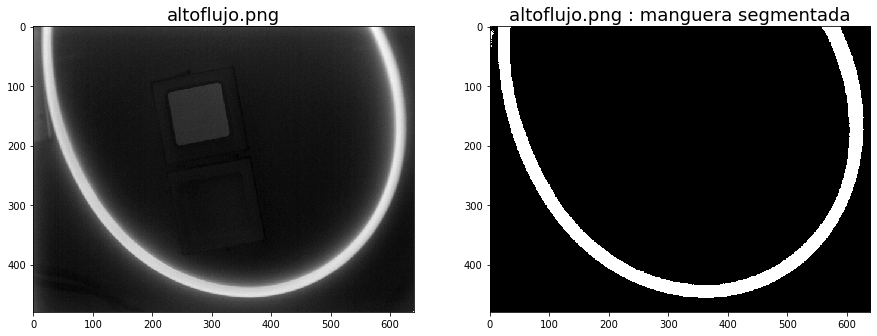

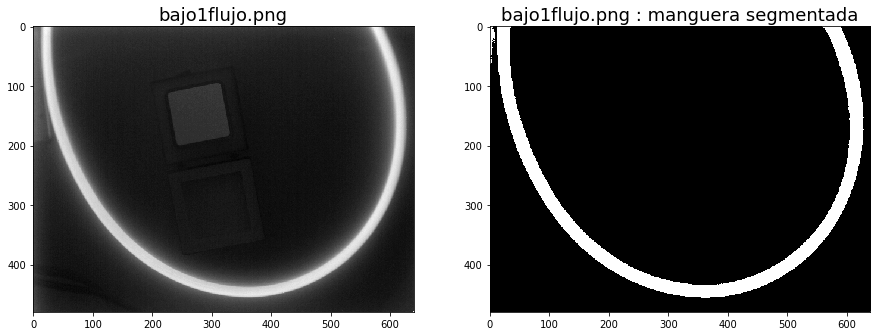

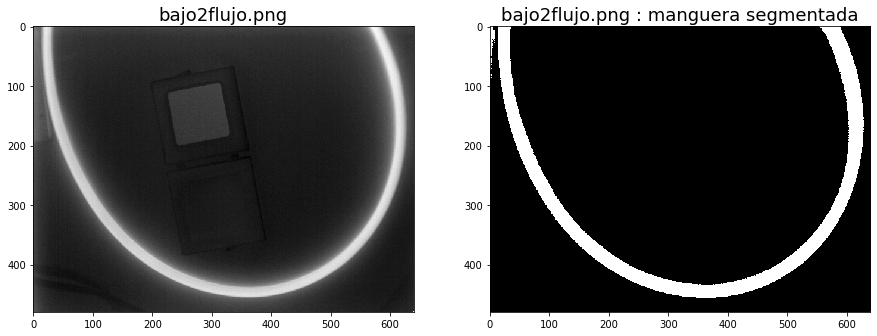

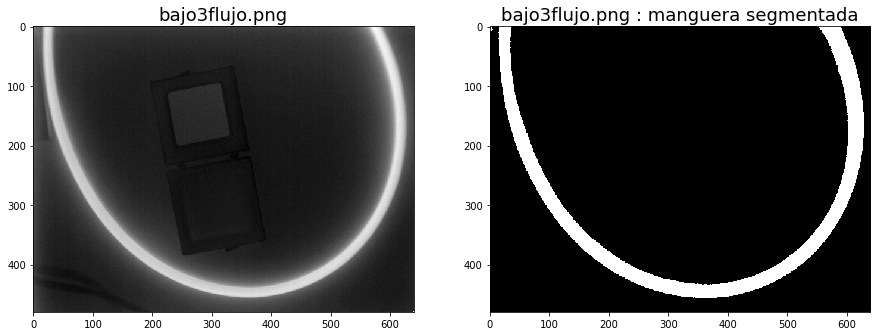

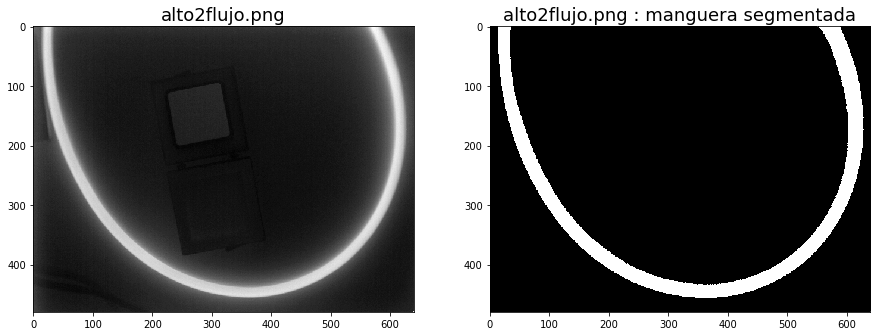

In [13]:
for nombre in mangueras.keys():
    utils.side_by_side(
        mangueras[nombre], mangueras_segmentadas[nombre], 
        title1=nombre, title2=f"{nombre} : manguera segmentada"
    )

Aquí podemos observar las imágenes con su respectiva máscara de segmentación.

In [14]:
region_ref1 = {
    key: auto_segment(mangueras[key], groups=3) for key in mangueras.keys()
}

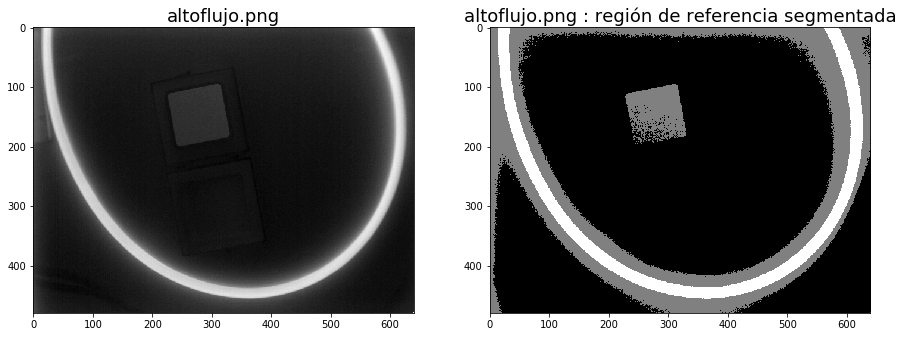

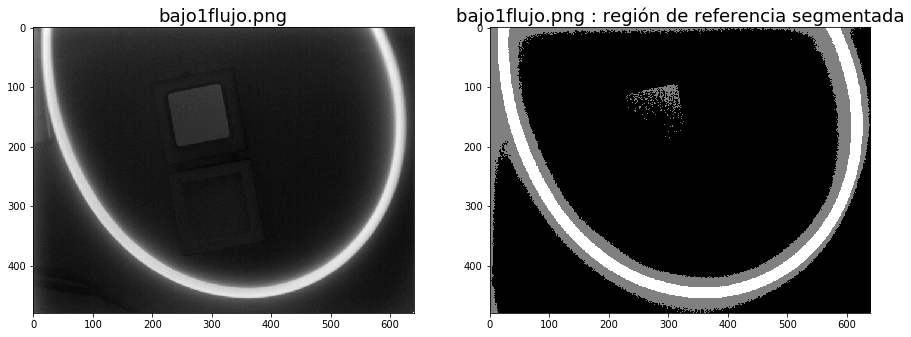

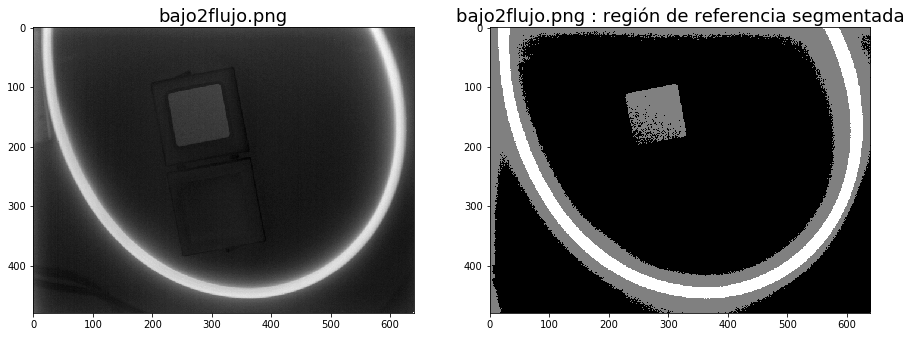

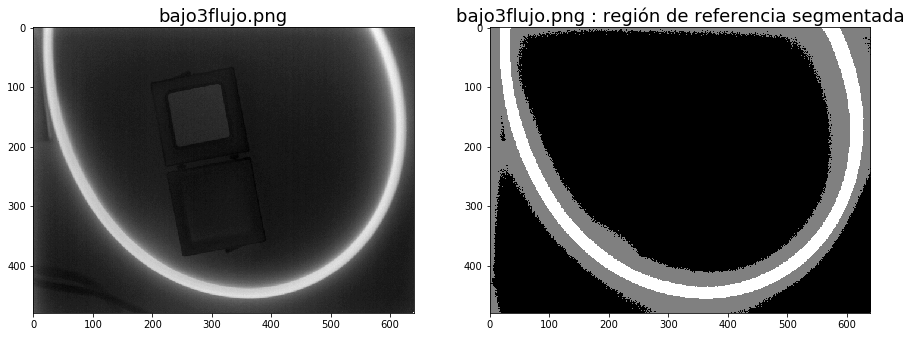

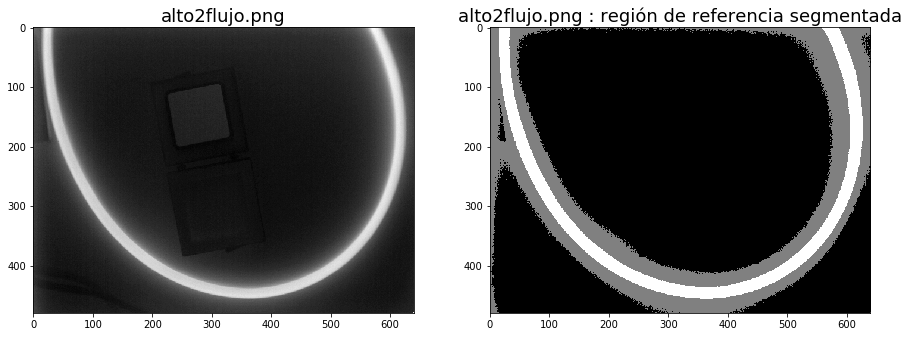

In [15]:
for nombre in mangueras.keys():
    utils.side_by_side(
        mangueras[nombre], region_ref1[nombre], 
        title1=nombre, title2=f"{nombre} : región de referencia segmentada"
    )

Aquí podemos observar que la referencia es más difícil de segmentar en función de las intensidades. 

La función fue llamada indicando que se buscaba una imagen trinaria ```auto_seg(img, groups=3)```
Se esperaba que esto permitiese segmentar la **región referencia** ya que ésta muestra una intensidad mayor a la del fondo pero menor a la de la manguera.

Tal vez quitando la región de la manguera (la de mayor intensidad) sea más fácil segmentar automáticamente la **región referencia**.

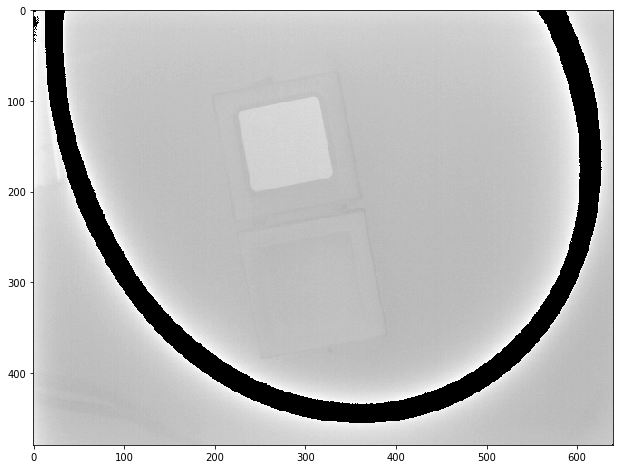

In [16]:
sin_manguera = {
    key: mangueras[key] * np.uint8(1.0 - mangueras_segmentadas[key])
    for key in mangueras_segmentadas.keys()
}
plt.imshow(sin_manguera[llaves[0]], cmap='gray')

Nótese que la imagen muestra en negro la región que antes mostraba la mayor intensidad.

In [17]:
sin_manguera = {
    key: mangueras[key] * np.uint8(1.0 - mangueras_segmentadas[key])
    for key in mangueras_segmentadas.keys()
}

In [18]:
region_ref2 = {
    key: auto_segment(sin_manguera[key], groups=2, nonzero=True) for key in sin_manguera.keys()
}

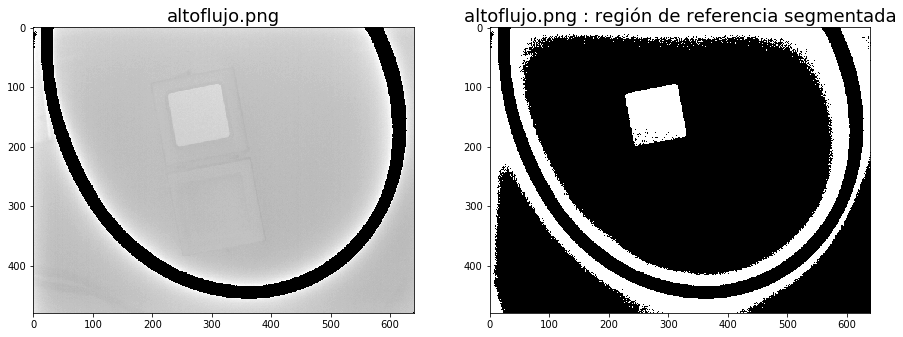

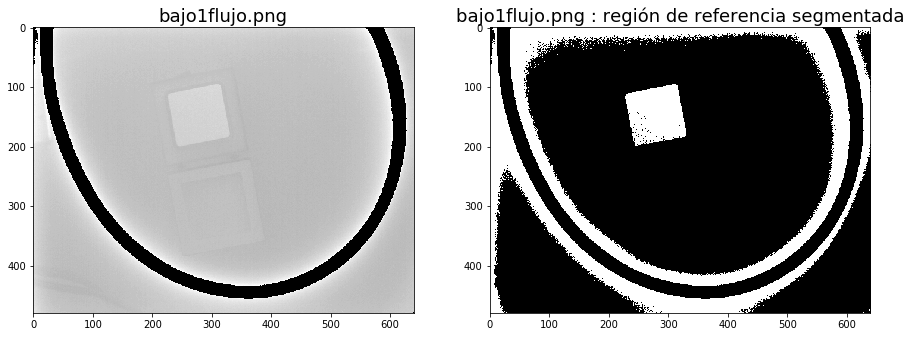

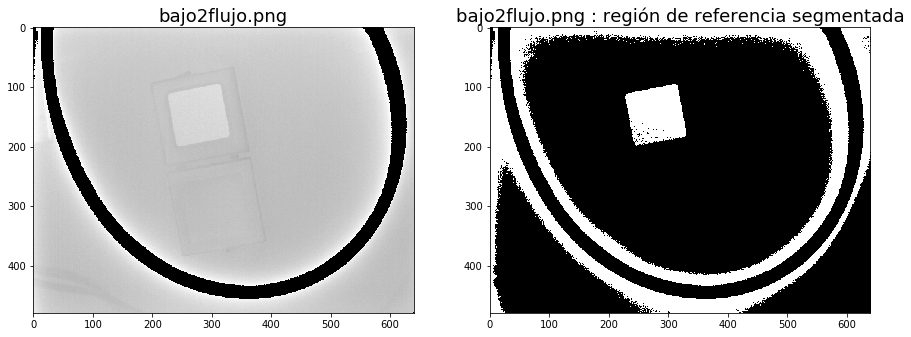

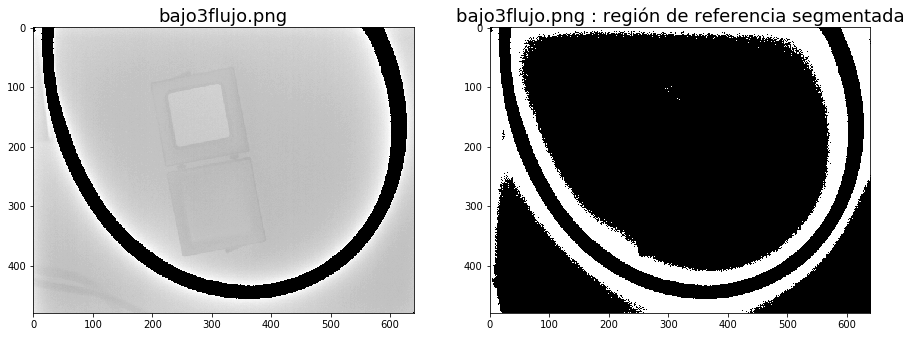

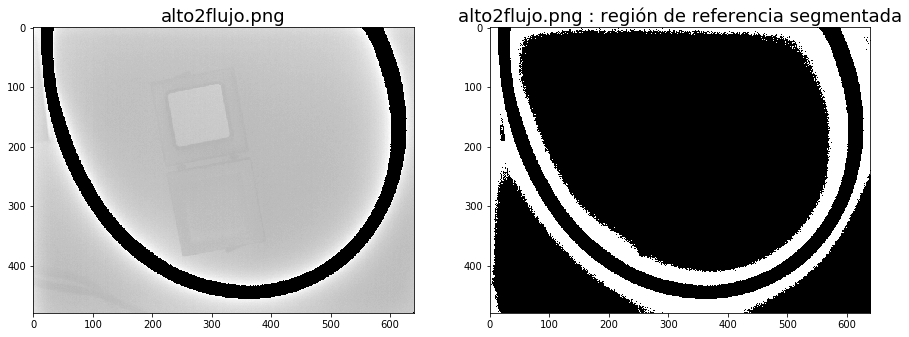

In [19]:
for nombre in sin_manguera.keys():
    utils.side_by_side(
        sin_manguera[nombre], region_ref2[nombre], 
        title1=nombre, title2=f"{nombre} : región de referencia segmentada"
    )

Aún teniendo la región de la manguera oscurecida, la función ```auto_seg()``` no permite segmentar la **región referencia** de forma automática. Esto podría atribuirse a que la forma del histograma de las ***imágenes con la manguera oscurecida*** sigue mostrando dos cúmulos principales como se muestra a continuación.

Sin embargo, debe notarse que la funcción ```auto_seg(.., nonzero=True)``` fue llamada con el parámetro ```nonzero=True```, lo que hace que la funcón ignore las entradas que valen 0 al momento de calcular los centros de los grupos.

Si se desea una visualización más detallada del funcionamiento de este parámetro, se recomienda correr este código, en dos celdas por separado para observar el efecto del parámetro ```nonzero``` :
```python
region_ref2 = {
    key: auto_segment(sin_manguera[key], groups=2, nonzero=True, verbose=True) for key in sin_manguera.keys()
}
```
por
```python
region_ref2 = {
    key: auto_segment(sin_manguera[key], groups=2, nonzero=False, verbose=True) for key in sin_manguera.keys()
}
```

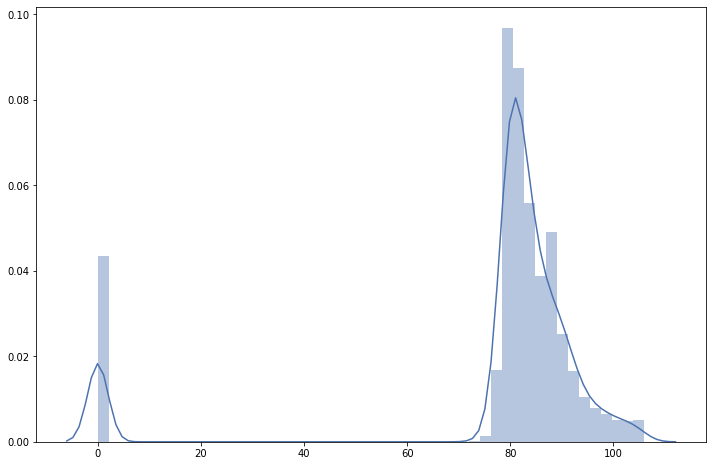

In [20]:
sns.distplot(sin_manguera[llaves[2]].flatten())

In [21]:
region_ref3 = {
    key: auto_segment(sin_manguera[key], groups=3, nonzero=True) for key in sin_manguera.keys()
}

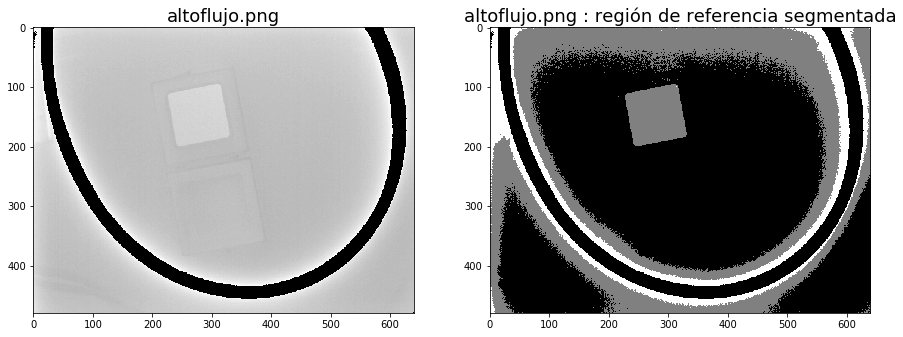

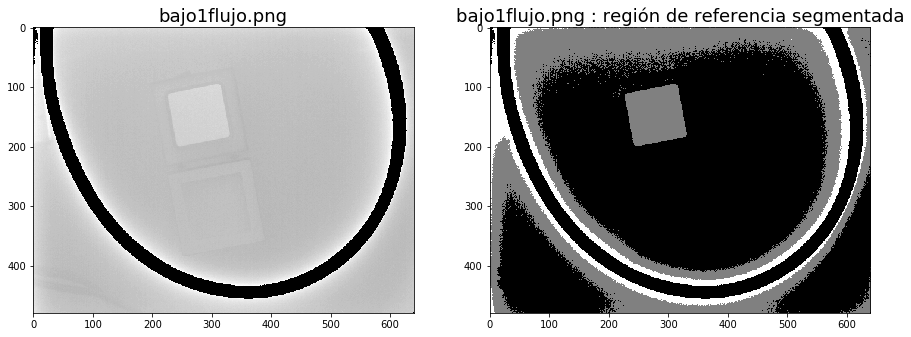

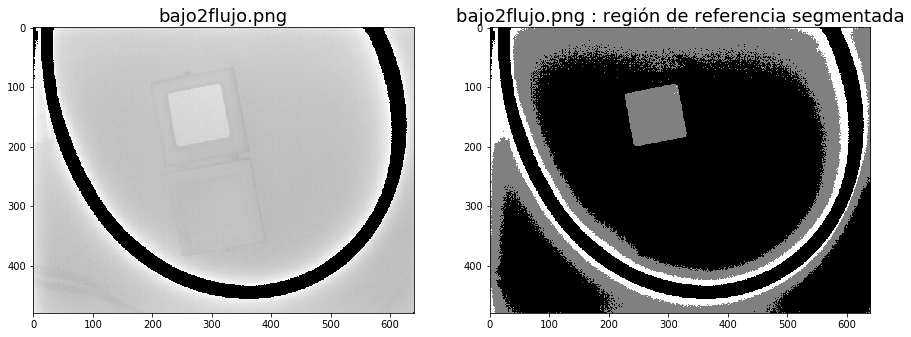

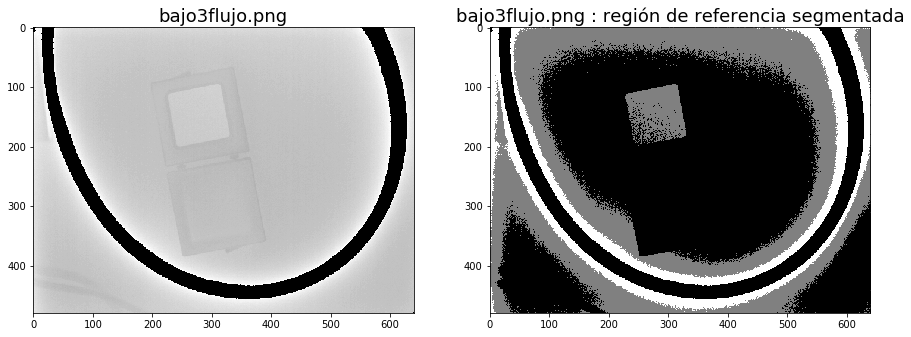

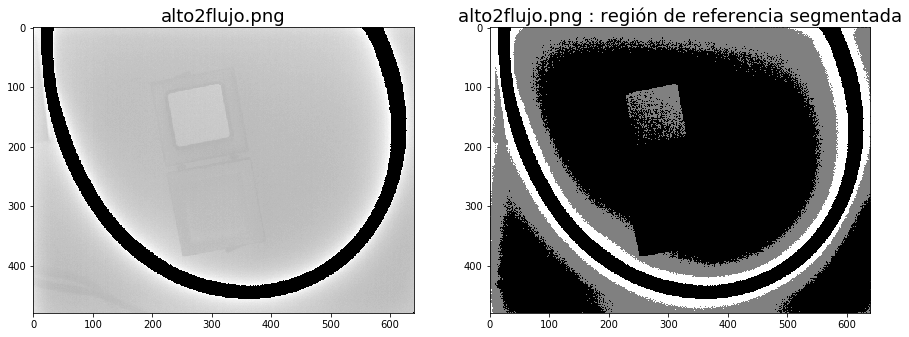

In [22]:
for nombre in sin_manguera.keys():
    utils.side_by_side(
        sin_manguera[nombre], region_ref3[nombre], 
        title1=nombre, title2=f"{nombre} : región de referencia segmentada"
    )

In [23]:
edges = canny(mangueras[llaves[0]] /255.)
fill_coins = ndi.binary_fill_holes(edges)

In [24]:
verbose = False

if verbose:
    for img1 in mangueras.values():
        ref_region(img1, verbose=True)

In [25]:
region_ref4 = {
    key: ref_region(mangueras[key]) for key in mangueras.keys()
}

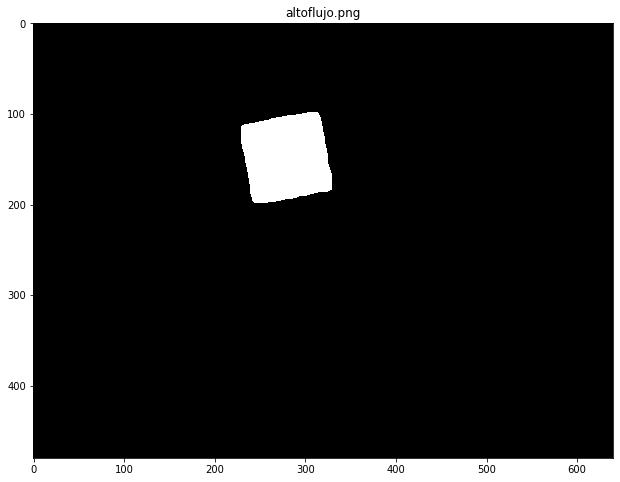

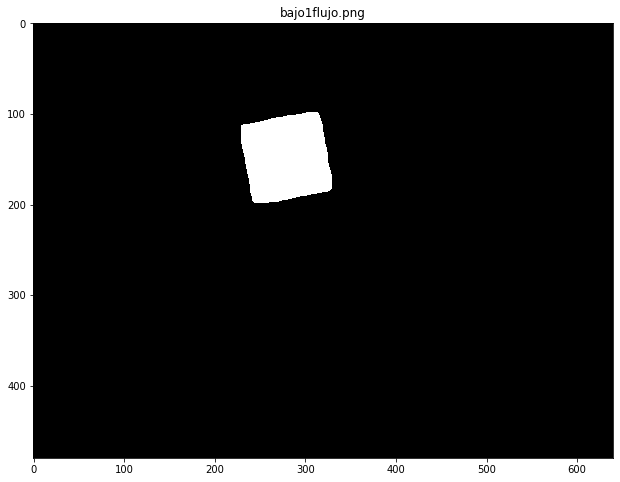

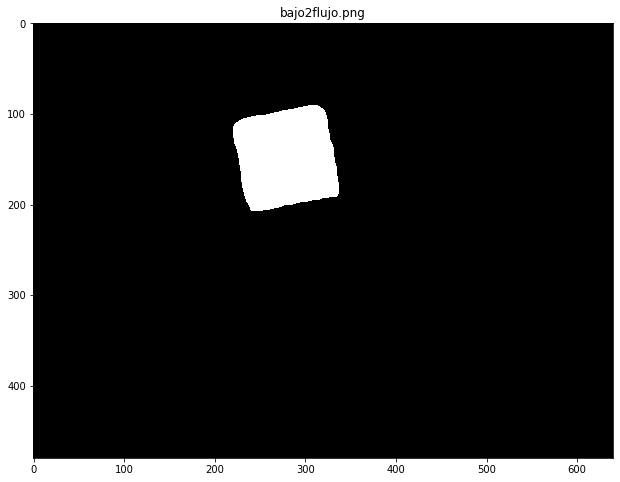

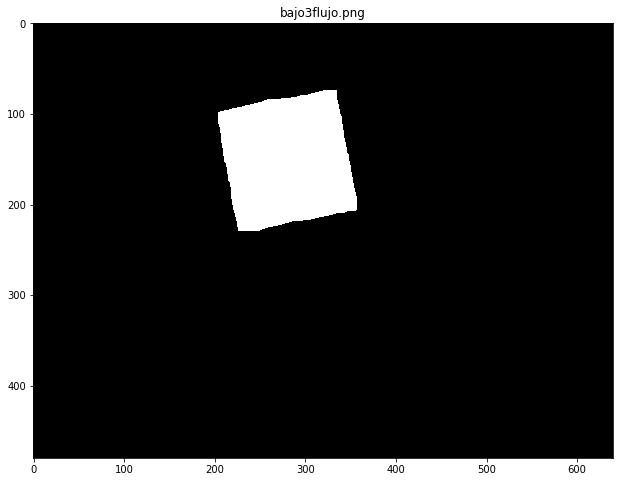

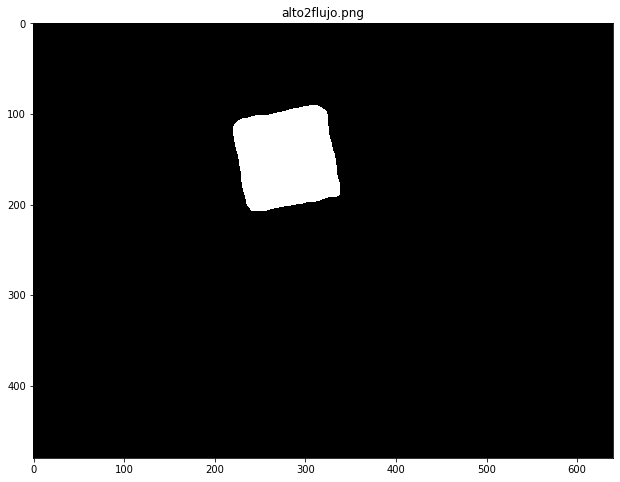

In [26]:
for nombre, imagen in zip(region_ref4.keys(), region_ref4.values()):
    plt.figure()
    plt.imshow(np.uint8(imagen), cmap="gray")
    plt.title(nombre)

In [27]:
segmented_ref_reg = {
    key: mangueras[key] * region_ref4[key] for key in llaves
}

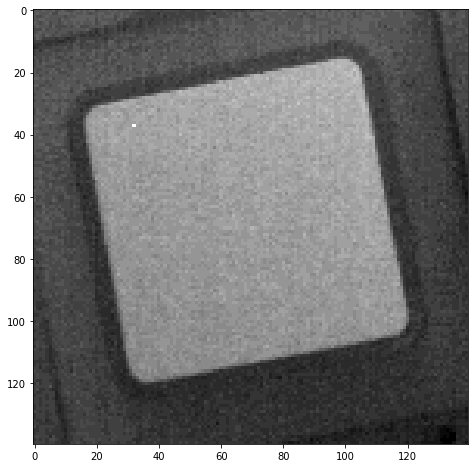

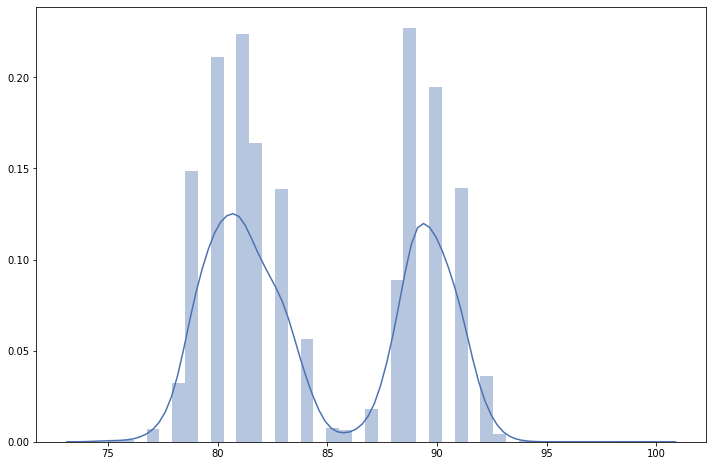

In [28]:
_tmp = copy.deepcopy(mangueras[llaves[0]][80:220, 210:350])
#_tmp[ _tmp < 85] = 0
#_tmp *= np.uint8( auto_segment(_tmp) * 255 )
plt.imshow(_tmp, cmap='gray')
plt.figure()
sns.distplot(_tmp.flatten()[_tmp.flatten().nonzero()])

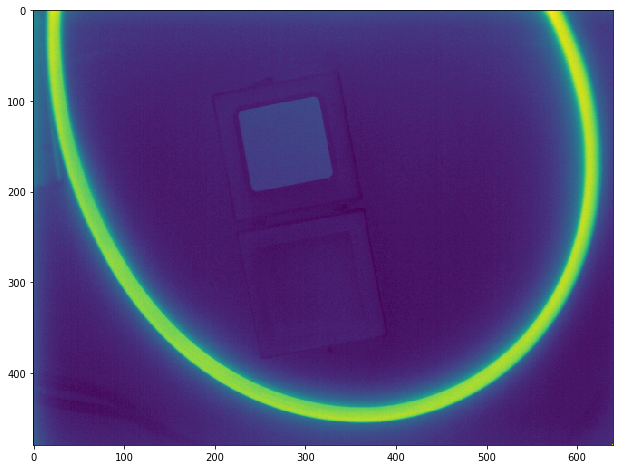

In [29]:
plt.imshow(mangueras[llaves[0]])

In [30]:
#_tmp = mangueras[llaves[0]][90:210, 200:350]
#_tmp = auto_segment(_tmp)
#plt.imshow(_tmp, cmap='gray')
#plt.figure()
#sns.distplot(mangueras[llaves[0]][_tmp.nonzero()].flatten())

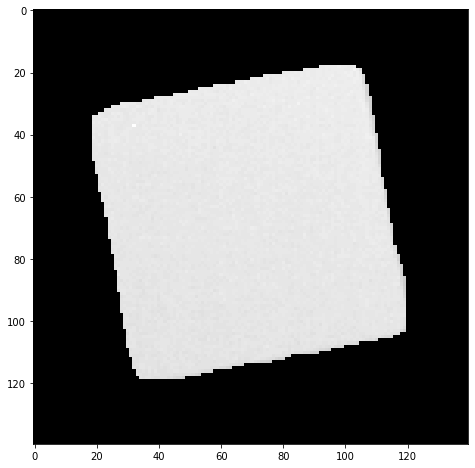

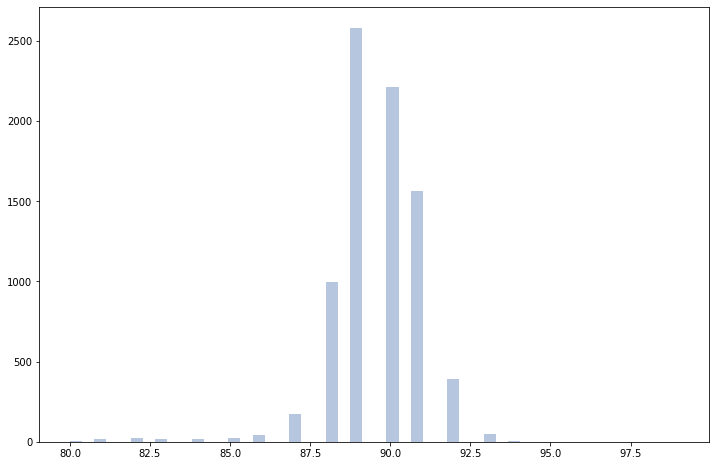

In [31]:
_tmp = copy.deepcopy(segmented_ref_reg[llaves[0]][80:220, 210:350])
plt.imshow(_tmp, cmap='gray')
plt.figure()
sns.distplot(_tmp[ _tmp != 0].flatten(), kde=False)


In [32]:
# Esto servía, pero ya no :
"""
region_info = pd.core.frame.DataFrame({
    f"{key.replace('.png', '')} ": value[ value != 0 ].flatten() for key, value in segmented_ref_reg.items() 
})
region_info.describe()
"""

'\nregion_info = pd.core.frame.DataFrame({\n    f"{key.replace(\'.png\', \'\')} ": value[ value != 0 ].flatten() for key, value in segmented_ref_reg.items() \n})\nregion_info.describe()\n'

In [33]:
region_info_list = list(map(
    lambda x, y: pd.core.series.Series(x[ x != 0].flatten(), name=y), segmented_ref_reg.values(), segmented_ref_reg.keys()
))
region_info = pd.concat(region_info_list, axis=1)

In [34]:
region_info.describe()

,altoflujo.png,bajo1flujo.png,bajo2flujo.png,bajo3flujo.png,alto2flujo.png
count,8111.000000,8144.000000,10736.000000,18376.000000,10839.000000
mean,89.573172,89.296537,87.485190,82.928766,84.963927
std,1.410561,1.432713,4.179704,3.440137,3.245888
min,80.000000,79.000000,77.000000,76.000000,76.000000
25%,89.000000,89.000000,87.000000,80.000000,84.000000
50%,90.000000,89.000000,89.000000,82.000000,86.000000
75%,90.000000,90.000000,90.000000,86.000000,87.000000
max,99.000000,99.000000,98.000000,95.000000,96.000000


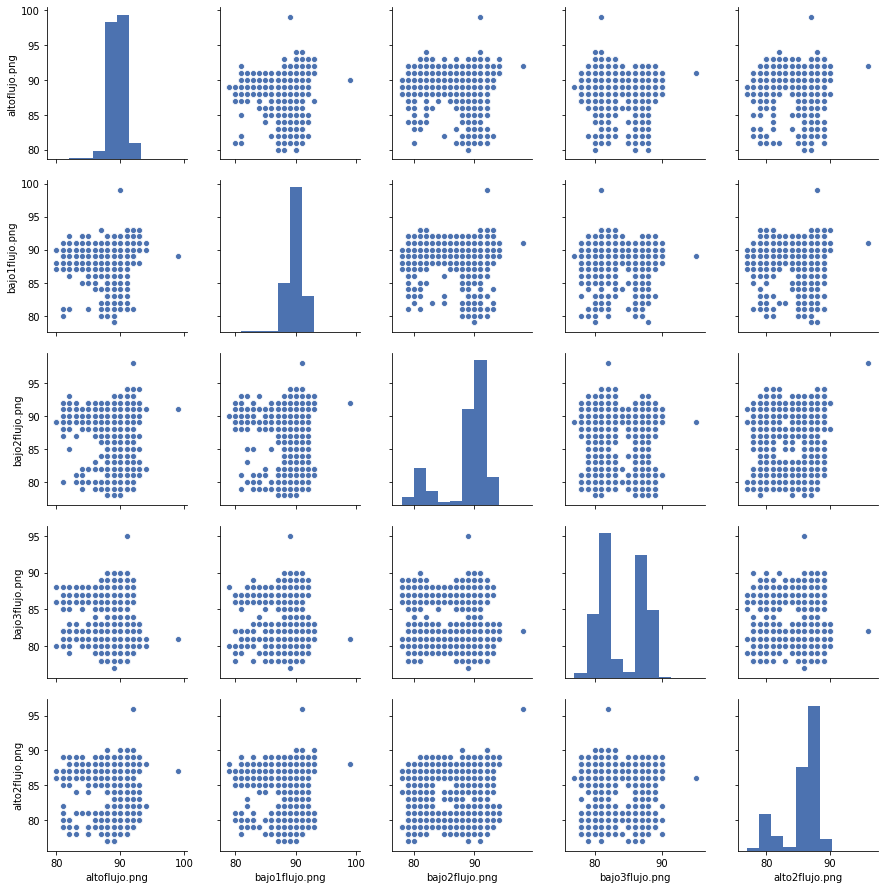

In [35]:
# Relatively slow, avoid running :
sns.pairplot(region_info.dropna())

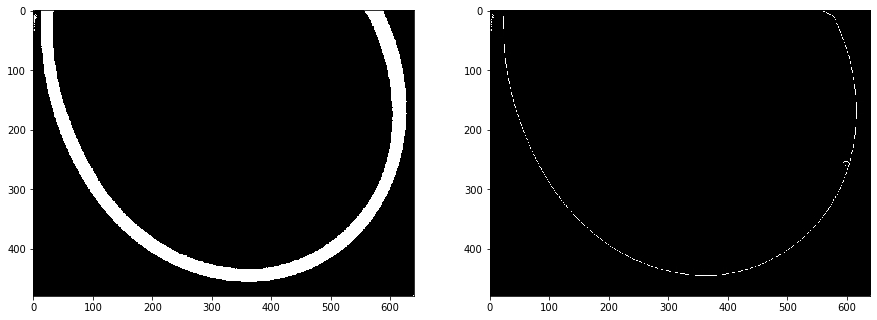

In [36]:
#find_branch_points(_hola).sum()
_tmp = mangueras_segmentadas[llaves[0]]
sk, ma, skl, th = skeletonize(_tmp), medial_axis(_tmp), skeletonize(_tmp, method='lee'), thin(_tmp)
la_buena = reduce(cv.bitwise_xor, lmap(np.uint8, [sk, skl, ma, th]))
utils.side_by_side(_tmp, la_buena)

In [37]:
mangueras_segmentadas_amano = {
    key: auto_segment(mangueras[key], verbose=False, groups=2, skew=5) for key in mangueras.keys()
}

In [69]:
mascaras_agregadas_2 = {
    key: reduce(cv.bitwise_xor, subdivide_hose(mangueras_segmentadas_amano[key], 2, contiguous=True)) for key in llaves
}

In [70]:
mascaras_subdivididas_2 = {
    key: subdivide_hose(mangueras_segmentadas_amano[key], 2, contiguous=True) for key in llaves
}

In [72]:
_plot = False

if _plot:
    for llave in llaves:
        plt.figure()
        plt.imshow(mascaras_agregadas_2[llave], cmap='gray')

In [73]:
mascaras_agregadas_6 = {
    key: reduce(cv.bitwise_xor, subdivide_hose(mangueras_segmentadas_amano[key], 6, contiguous=False)) for key in llaves
}

In [74]:
mascaras_subdivididas_6 = {
    key: subdivide_hose(mangueras_segmentadas_amano[key], 6, contiguous=False) for key in llaves
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


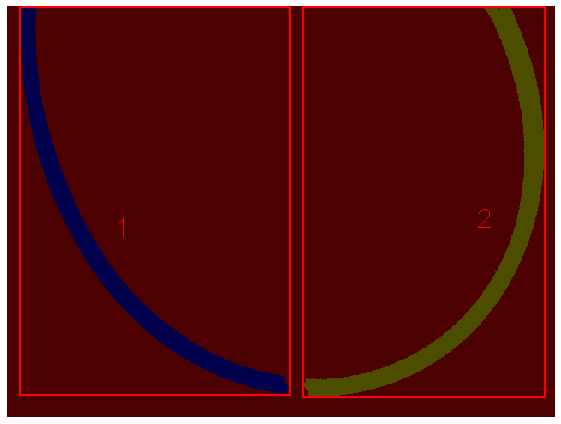

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


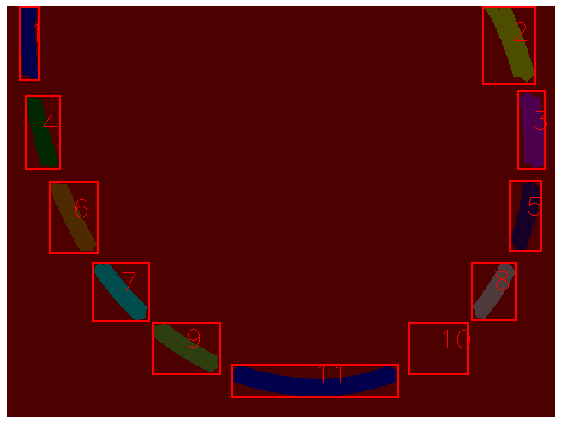

In [75]:
plot_label_image_regions(mascaras_agregadas_2[llaves[3]])
plot_label_image_regions(mascaras_agregadas_6[llaves[3]])

In [76]:
mangueras_subdivididas_2 = {
    key: mangueras[key] * mascaras_subdivididas_2[key] for key in llaves
}

In [84]:
mangueras_agregadas_2 = {
    key: mangueras[key] * mascaras_agregadas_2[key] for key in llaves
}

In [85]:
mangueras_agregadas_6 = {
    key: mangueras[key] * mascaras_agregadas_6[key] for key in llaves
}

In [86]:
#plt.imshow(mangueras_subdivididas_2[llaves[0]][1])

In [87]:
#plt.imshow(mangueras_subdivididas_2[llaves[0]], cmap='gray')

In [90]:
mangueras_subdivididas_2[llaves[0]][0]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [115]:
def gen_tabla_subdivididas(y: Dict[str, List[np.ndarray]]) -> pd.core.frame.DataFrame:
    """
        Generate dianostic tables.
    """
    
    return pd.core.frame.DataFrame({
        "Num. pixeles": [len(x[ x != 0]) for x in y ],
        "Intensidad media": [ x[ x != 0].mean() for x in y ],
        "Varianza": [ x[ x != 0].std()**2 for x in y ]
    })

In [116]:
y = mangueras_subdivididas_2[llaves[0]]
[type(x) for x in y]

[numpy.ndarray, numpy.ndarray]

In [117]:
tabla_2_secciones = {
    key: gen_tabla_subdivididas(value) for key, value in mangueras_subdivididas_2.items()
}

In [120]:
tabla_6_secciones = {
    key: gen_tabla_subdivididas(value) for key, value in mangueras_subdivididas_6.items()
}

In [122]:
#print(tabla_2_secciones[llaves[1]])
tabla_6_secciones[llaves[1]]

,Num. pixeles,Intensidad media,Varianza
0,4211,135.252909,94.696664
1,4994,133.903484,73.682315
2,5095,134.155054,63.911189
3,4704,134.813776,57.357327
4,4931,135.631312,58.898342
5,4669,135.963804,60.021607


134.84886564898372 55.51515284161077


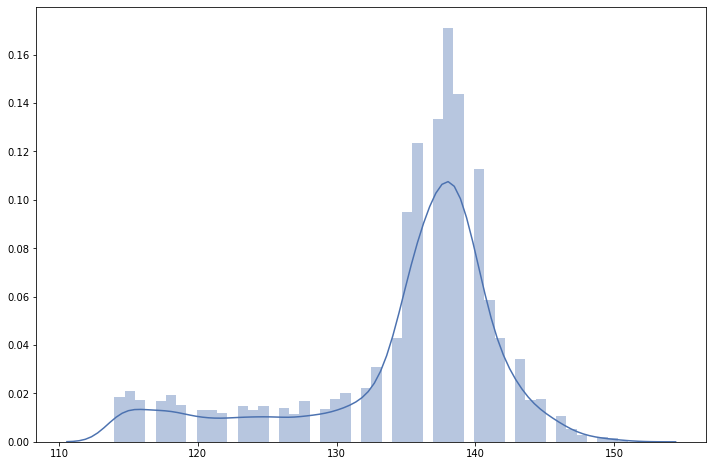

In [119]:
_sec1 = mangueras_subdivididas_2[llaves[1]][0]
_data1 = _sec1[ _sec1 != 0].flatten()
print(_data1.mean(), _data1.std()**2)
sns.distplot(_data1)

In [68]:
_plot = False

if _plot:
    for llave in llaves:
        plt.figure()
        plt.imshow(mangueras_subdivididas_6[llave], cmap='gray')